# Linear Regression

This notebook implements linear regression, a supervised learning technique for predicting numerical values given a set of features. For details on the algorithm, check out the [`README`](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/linear_regression/README.md) in this subdirectory!

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

from matplotlib.lines import Line2D

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split

# Set the Seaborn theme
sns.set_theme()

## The Data

A linear regression model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

First, I read in the dataset into a pandas DataFrame object, and subset the DataFrame to observations containing no missing values for all the variables of interest. Afterwards, the full dataset is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. 
* This process is detailed in Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb).

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Age", "Wing", "Weight", "Culmen", "Hallux", "Tail"]].dropna(axis=0)
hawks

,Species,Age,Wing,Weight,Culmen,Hallux,Tail
0,RT,I,385.0,920.0,25.7,30.1,219
2,RT,I,381.0,990.0,26.7,31.3,235
3,CH,I,265.0,470.0,18.7,23.5,220
4,SS,I,205.0,170.0,12.5,14.3,157
5,RT,I,412.0,1090.0,28.5,32.2,230
...,...,...,...,...,...,...,...
903,RT,I,380.0,1525.0,26.0,27.6,224
904,SS,I,190.0,175.0,12.7,15.4,150
905,RT,I,360.0,790.0,21.9,27.6,211
906,RT,I,369.0,860.0,25.2,28.0,207


## Training the model: a custom class

To implement linear regression, I create this custom class with all the necessary functionalities outlined by the algorithm, found in the `README.md` file of this `linear_regression` directory.

In [3]:
class LinearRegression:
    """
    A class to fit a linear regression model to data and obtain model diagnostics.

    ...

    Attributes
    ----------
    weights : numpy array (of floats)
        Parameters of the trained models, organized as [w_bias, w_1, w_2, ..., w_n]
    train_errors: list of floats
        Each entry in this list is an error calculated during training iterations
    """
    
    def __init__(self):
        self.weights = None
        self.train_errors = []
    
    def train(self, X, y, rate=0.05, iterations=1000):
        """
        Train a linear regression model

        Parameters
        ----------
        X: matrix of feature values
        y: array of observed values
        rate (float): learning rate
        iterations (int): number of iterations to train the model for

        Returns: None
        """
        n_obs, n_features = X.shape

        # Initialize coefficients/weights and intercept/bias from a uniform distribution
        self.weights = np.random.rand(n_features + 1)
        
        # Implement stochastic gradient decent
        for _ in range(iterations):
            total_error = 0
            for i in range(0, n_obs):
                err = self.predict(X[i,]) - y[i]
                self.weights -= rate * err * np.insert(X[i,], 0, 1)
                #print(i, err)
                total_error += 0.5 * err**2
            self.train_errors.append(total_error / n_obs)
            
    def predict(self, X):
        """
        Obtain the predicted values given a matrix of features
        """
        X = np.insert(X, 0, 1)
        return np.dot(X, self.weights)

First, I test this class on some sample simulated data.

In [4]:
X = np.array([[1,2], [3,4], [5,6]])
y = np.array([7, 8, 9])

lin_model = LinearRegression()
lin_model.train(X, y, 0.01, 1000)

print(lin_model.weights) # prints the model parameters

[ 4.20730632 -1.79137843  2.29162291]


## Model 1: Predicting Tail Length From Wing Length

As one sees from the scatterplot below, there appears to be a linear relationship between wing length and tail length, although it arguably could be better. As the wing length increases by 1 mm, there appears to be a linear increase in tail length. Thus, a potential linear regression model would be to predict a hawk's tail length from their wing length, and this is what will be modeled first.

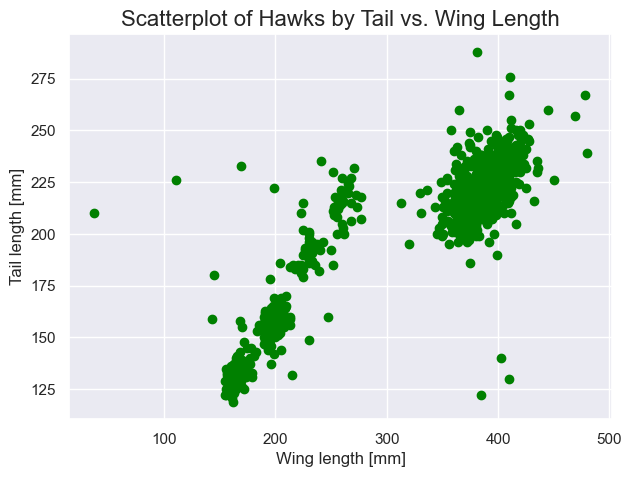

In [5]:
plt.figure(figsize = (7, 5))
plt.scatter(hawks.Wing, hawks.Tail, color = "green")
plt.title("Scatterplot of Hawks by Tail vs. Wing Length", fontsize = 16)
plt.xlabel("Wing length [mm]", fontsize = 12)
plt.ylabel("Tail length [mm]", fontsize = 12)
plt.show()

### Splitting the data to train model 1

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [6]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Wing"]].to_numpy()
y = hawks["Tail"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Now, I train a linear regression model for the Hawk data to predict tail length from wing length using the class defined previously.

The learning rate of `0.00001` was determined using trial and error. I started off with a learning rate of 0.01, but found that there would be overflow errors. The error calculated at each step of stochastic gradient descent would be too large, causing the weights to fail to converge. I added zeroes to the initial learning rate and increased the number of epochs/iterations until the current learning rate of `0.00001` and `5000` iterations produced satisfactory results.

In [7]:
tail_model = LinearRegression()
tail_model.train(X_train, y_train, 0.00001, 5000)

print(tail_model.weights) # prints the model parameters

[82.14246273  0.34537129]


The model we have can be written as ...

In the next block of code, I display a scatterplot of tail vs. wing length for both training and testing set, with the linear regression line.

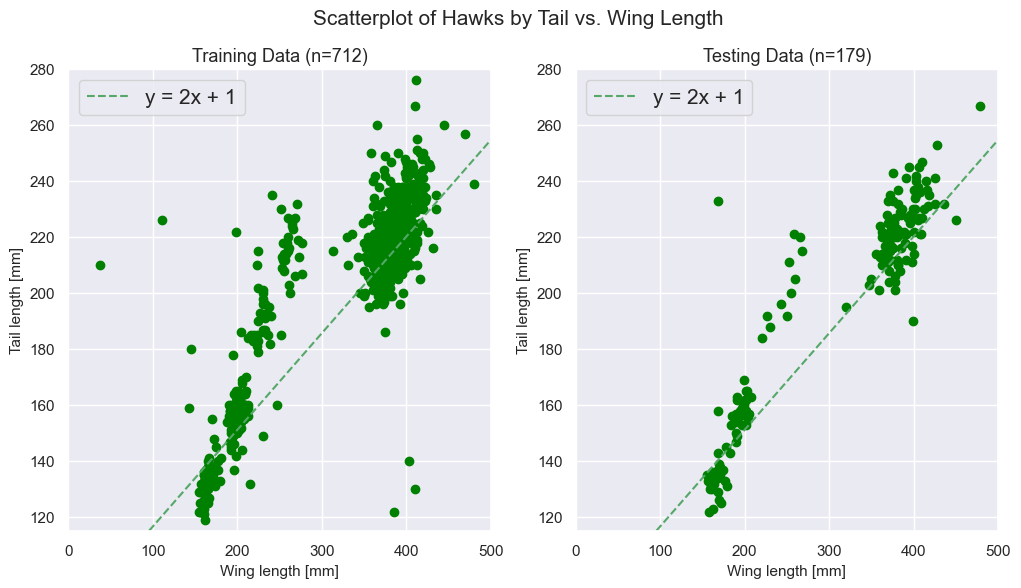

In [8]:
# Obtain the linear regression line
x = np.linspace(0,500,100)
y = tail_model.weights[0] + tail_model.weights[1]*x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Scatterplot of Hawks by Tail vs. Wing Length", fontsize = 15)
# Plot the training set
ax1.set_xlim((0, 500))
ax1.set_ylim((115, 280))
ax1.scatter(X_train, y_train, color = "green")
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Tail length [mm]", fontsize = 11)
ax1.set_title("Training Data (n=712)", fontsize = 13)
ax1.plot(x, y, '--g', label='y = 2x + 1')
ax1.legend(fontsize = 15, loc = "upper left")

# Plot the testing set
ax2.set_xlim((0, 500))
ax2.set_ylim((115, 280))
ax2.scatter(X_test, y_test, color = "green")
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Tail length [mm]", fontsize = 11)
ax2.set_title("Testing Data (n=179)", fontsize = 13)
ax2.plot(x, y, '--g', label='y = 2x + 1')
ax2.legend(fontsize = 15, loc = "upper left")
plt.show()

### Performance/error analysis for model 1

### Linear Regression by Species

For fun, I run the linear regression algorithm for each of the three hawk species. I'm curious whether there will be any different results in terms of slope.

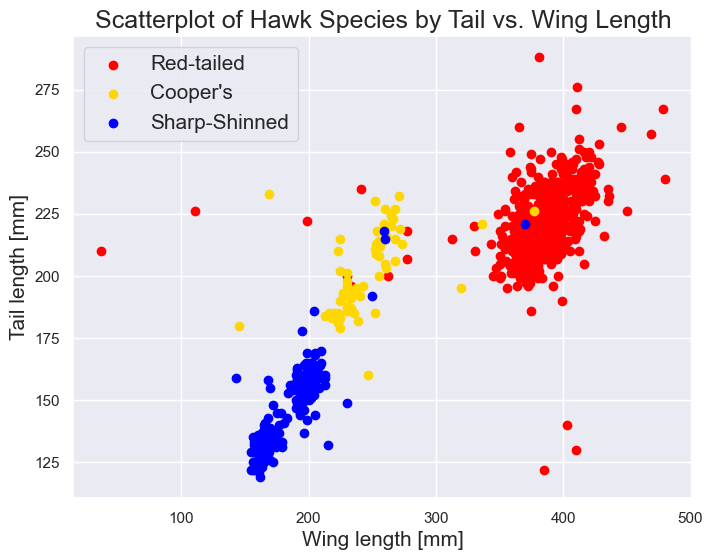

In [9]:
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
RT = hawks[hawks.Species == "RT"]
CH = hawks[hawks.Species == "CH"]
SS = hawks[hawks.Species == "SS"]

plt.figure(figsize = (8, 6))
plt.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
plt.scatter(CH.Wing, CH.Tail, color = "gold", label = "Cooper's")
plt.scatter(SS.Wing, SS.Tail, color = "blue", label = "Sharp-Shinned")
plt.title("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 18)
plt.xlabel("Wing length [mm]", fontsize = 15)
plt.ylabel("Tail length [mm]", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.show()

In [10]:
tail_model_RT = LinearRegression()
tail_model_RT.train(np.array(RT.Wing).reshape(-1, 1), np.array(RT.Tail), 0.00001, 5000)

tail_model_CH = LinearRegression()
tail_model_CH.train(np.array(CH.Wing).reshape(-1, 1), np.array(CH.Tail), 0.00001, 5000)

tail_model_SS = LinearRegression()
tail_model_SS.train(np.array(SS.Wing).reshape(-1, 1), np.array(SS.Tail), 0.00001, 5000)

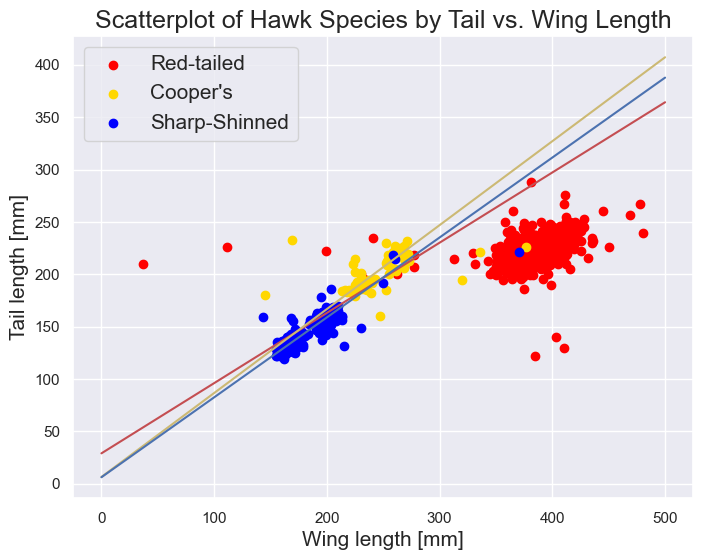

In [11]:
plt.figure(figsize = (8, 6))
plt.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
plt.scatter(CH.Wing, CH.Tail, color = "gold", label = "Cooper's")
plt.scatter(SS.Wing, SS.Tail, color = "blue", label = "Sharp-Shinned")
plt.title("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 18)
plt.xlabel("Wing length [mm]", fontsize = 15)
plt.ylabel("Tail length [mm]", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")

x = np.linspace(0,500,100)
#y = tail_model.weights[0] + tail_model.weights[1]*x
plt.plot(x, tail_model_RT.weights[0] + tail_model_RT.weights[1]*x, '-r', label='y=2x+1')
plt.plot(x, tail_model_CH.weights[0] + tail_model_CH.weights[1]*x, '-y', label='y=2x+1')
plt.plot(x, tail_model_SS.weights[0] + tail_model_SS.weights[1]*x, '-b', label='y=2x+1')
plt.show()

The lines actually all look fairly similar on the plot above! An increase in wing length results in a linear increase in tail length regardless of hawk species.

### Using scikit-learn

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(89.96225898571478, array([0.3447985]))

The coefficients produced from scikit-learn are comparable to those weights outputted from the trained model!